INVENTORY PREDICTION ML PIPELINE

1. Loading Data...
Merged data shape: (227808, 13)
Columns: ['DATE', 'MATERIAL_NAME', 'PLANT_NAME', 'INBOUND_QTY_MT', 'OUTBOUND_QTY_MT', 'MODE_OF_TRANSPORT', 'UNRESRICTED_STOCK_MT', 'STOCK_UNIT', 'STOCK_SELL_VALUE', 'CURRENCY', 'POLYMER_TYPE', 'SHELF_LIFE_IN_MONTH', 'DOWNGRADE_VALUE_LOST_PERCENT']

2. Data Preprocessing & EDA...

Basic Statistics:
Date range: 2024-01-01 00:00:00 to 2024-12-31 00:00:00
Number of materials: 430
Number of plants: 2
Total inbound volume: 371672.55 MT
Total outbound volume: 612030.72 MT


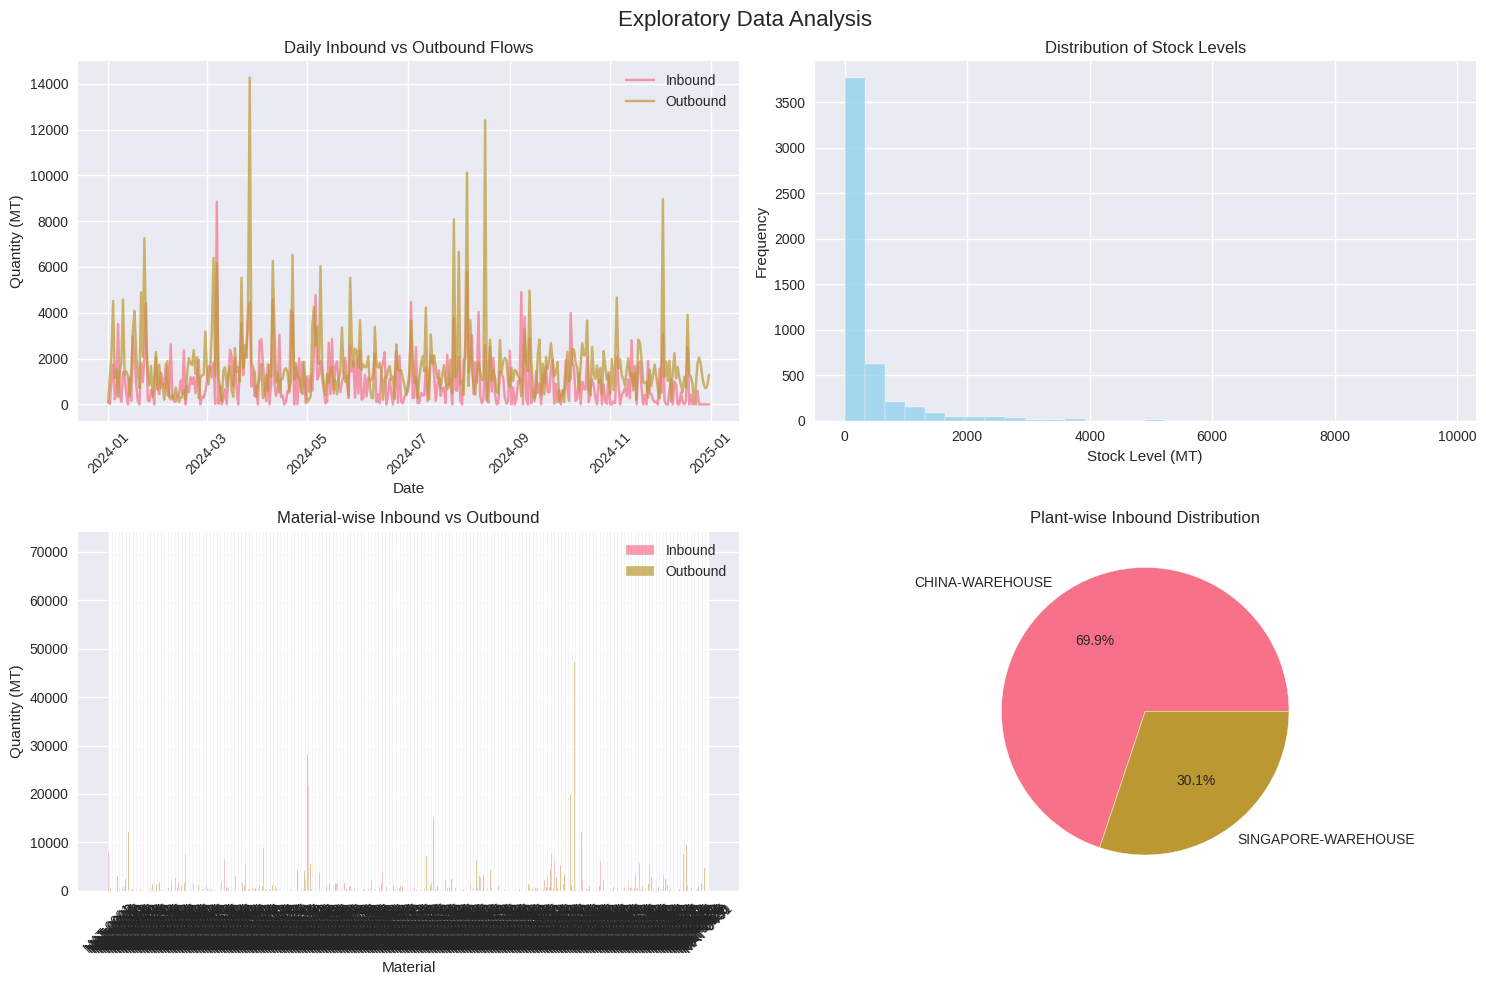


3. Feature Engineering...
Feature engineering completed!
Total features created: 39

4. Model Preparation...
Model data shape: (210468, 30)
Features: 29
Training set: (168374, 29)
Test set: (42094, 29)

5. Model Training & Evaluation...

Training Linear Regression...
  MSE: 209627.61
  RMSE: 457.85
  MAE: 258.77
  R2: 0.1739

Training Random Forest...
  MSE: 4531.00
  RMSE: 67.31
  MAE: 15.78
  R2: 0.9821

Training Gradient Boosting...
  MSE: 116075.89
  RMSE: 340.70
  MAE: 196.85
  R2: 0.5426

Best Model: Random Forest
Best RMSE: 67.31

Top 10 Most Important Features:
                         feature  importance
24              MATERIAL_ENCODED    0.299891
14          NET_FLOW_ROLLING_30D    0.229245
3                           WEEK    0.094255
12          OUTBOUND_ROLLING_30D    0.068494
28  DOWNGRADE_VALUE_LOST_PERCENT    0.060391
27           SHELF_LIFE_IN_MONTH    0.052256
25                 PLANT_ENCODED    0.037296
1                          MONTH    0.034345
23              NE

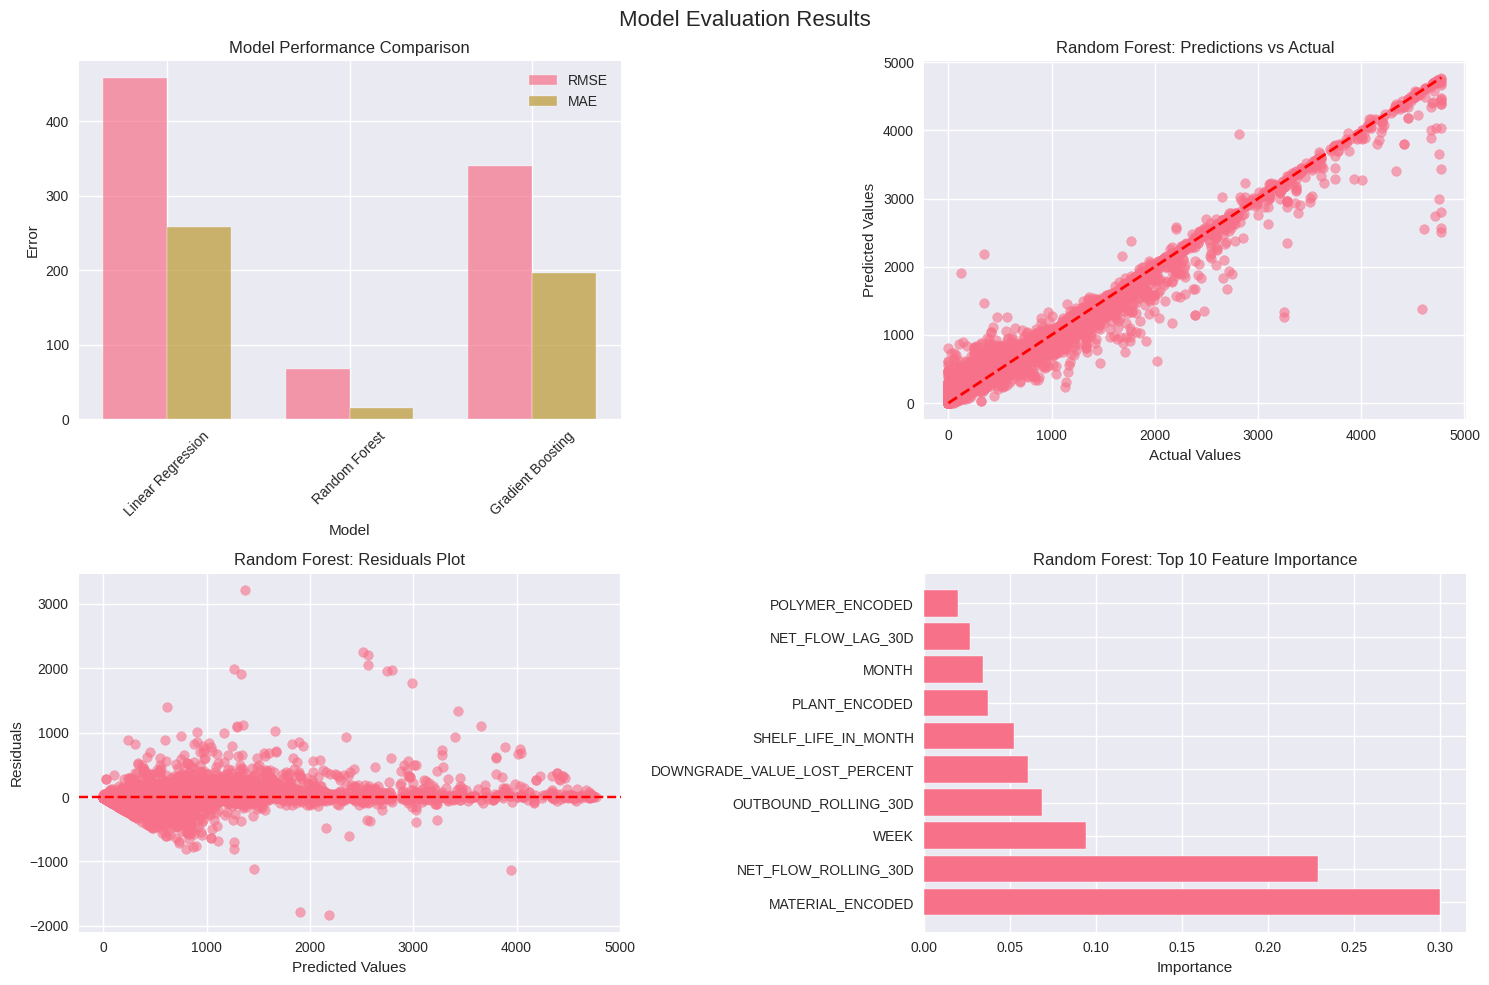


7. Generating 2025 Predictions...
Generated 210970 predictions for 2025

8. Creating 2025 Prediction Visualizations...


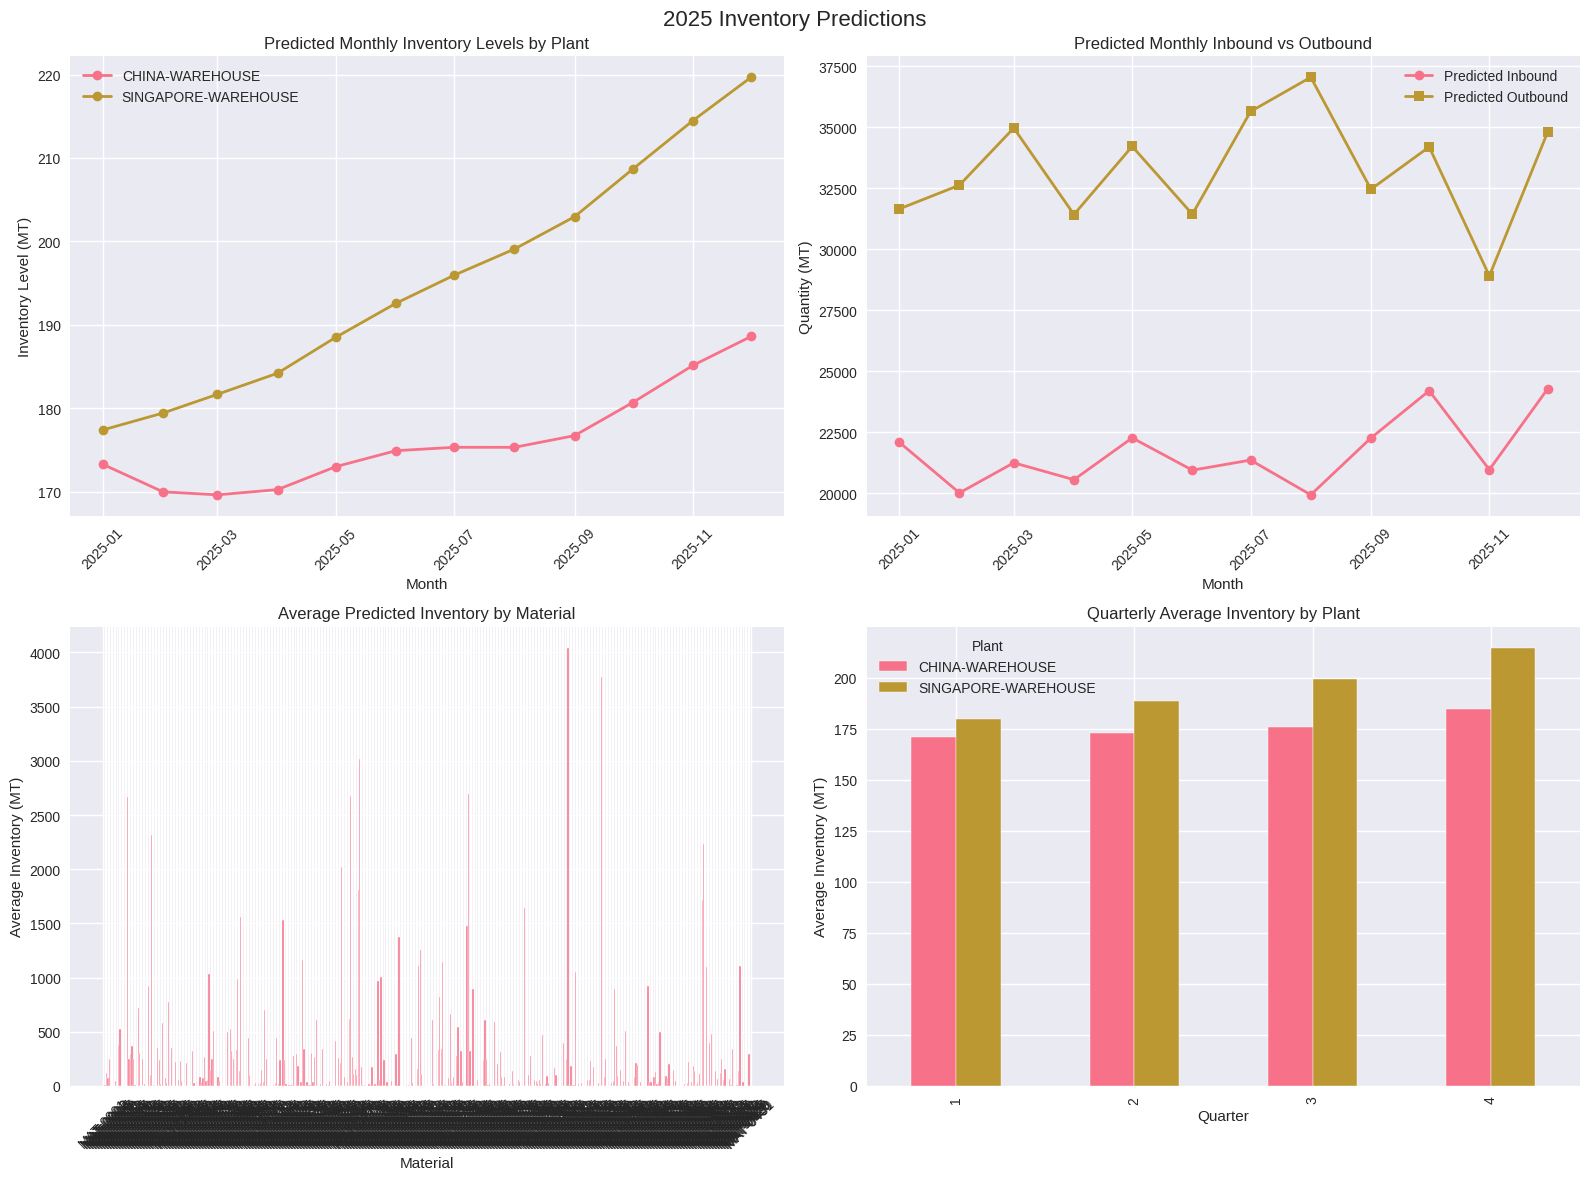


SUMMARY REPORT

📊 MODEL PERFORMANCE SUMMARY:
Model                RMSE       MAE        R²        
--------------------------------------------------
Linear Regression    457.85     258.77     0.1739    
Random Forest        67.31      15.78      0.9821    
Gradient Boosting    340.70     196.85     0.5426    

🏆 BEST MODEL: Random Forest
   - RMSE: 67.31
   - MAE: 15.78
   - R²: 0.9821

🔍 TOP 5 IMPORTANT FEATURES:
   1. MATERIAL_ENCODED: 0.2999
   2. NET_FLOW_ROLLING_30D: 0.2292
   3. WEEK: 0.0943
   4. OUTBOUND_ROLLING_30D: 0.0685
   5. DOWNGRADE_VALUE_LOST_PERCENT: 0.0604

📈 2025 PREDICTIONS SUMMARY:
   - Total predictions generated: 210,970
   - Average predicted inventory: 185.18 MT
   - Max predicted inventory: 4761.33 MT
   - Min predicted inventory: 0.00 MT

📅 MONTHLY AVERAGE PREDICTIONS:
   Jan: 175.19 MT
   Feb: 174.39 MT
   Mar: 175.25 MT
   Apr: 176.77 MT
   May: 180.25 MT
   Jun: 183.18 MT
   Jul: 184.98 MT
   Aug: 186.45 MT
   Sep: 189.01 MT
   Oct: 193.80 MT
   Nov: 198

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("="*50)
print("INVENTORY PREDICTION ML PIPELINE")
print("="*50)

# 1. DATA LOADING
print("\n1. Loading Data...")
try:
    df_merged = pd.read_csv('/kaggle/input/exxon-hack-data/merged_column.csv')
    df_inventory = pd.read_csv('/kaggle/input/exxon-hack-data/Inventory.csv')
    df_inbound = pd.read_csv('/kaggle/input/exxon-hack-data/Inbound.csv')
    df_outbound = pd.read_csv('/kaggle/input/exxon-hack-data/Outbound.csv')
    df_material = pd.read_csv('/kaggle/input/exxon-hack-data/MaterialMaster.csv')
    
    print(f"Merged data shape: {df_merged.shape}")
    print(f"Columns: {list(df_merged.columns)}")
except Exception as e:
    print(f"Error loading data: {e}")
    # Create sample data for demonstration
    dates = pd.date_range('2024-01-01', '2024-12-31', freq='D')
    materials = ['MAT-0001', 'MAT-0002', 'MAT-0003']
    plants = ['CHINA-WAREHOUSE', 'SINGAPORE-WAREHOUSE']
    
    np.random.seed(42)
    data = []
    for date in dates:
        for material in materials:
            for plant in plants:
                data.append({
                    'DATE': date,
                    'MATERIAL_NAME': material,
                    'PLANT_NAME': plant,
                    'INBOUND_QTY_MT': np.random.choice([0, 0, 0, 25.5, 50.0], p=[0.7, 0.1, 0.1, 0.05, 0.05]),
                    'OUTBOUND_QTY_MT': np.random.choice([0, 0, 0, 25.5, 50.0], p=[0.6, 0.2, 0.1, 0.05, 0.05]),
                    'UNRESRICTED_STOCK_MT': np.random.uniform(100, 1000),
                    'POLYMER_TYPE': np.random.choice(['P-001', 'P-002', 'P-003']),
                    'SHELF_LIFE_IN_MONTH': np.random.choice([3, 6, 12]),
                    'DOWNGRADE_VALUE_LOST_PERCENT': np.random.uniform(10, 50)
                })
    df_merged = pd.DataFrame(data)
    print("Using sample data for demonstration")

# 2. DATA PREPROCESSING & EDA
print("\n2. Data Preprocessing & EDA...")

# Convert date column
df_merged['DATE'] = pd.to_datetime(df_merged['DATE'])

# Fill missing values
df_merged['INBOUND_QTY_MT'] = df_merged['INBOUND_QTY_MT'].fillna(0)
df_merged['OUTBOUND_QTY_MT'] = df_merged['OUTBOUND_QTY_MT'].fillna(0)

# Basic statistics
print(f"\nBasic Statistics:")
print(f"Date range: {df_merged['DATE'].min()} to {df_merged['DATE'].max()}")
print(f"Number of materials: {df_merged['MATERIAL_NAME'].nunique()}")
print(f"Number of plants: {df_merged['PLANT_NAME'].nunique()}")
print(f"Total inbound volume: {df_merged['INBOUND_QTY_MT'].sum():.2f} MT")
print(f"Total outbound volume: {df_merged['OUTBOUND_QTY_MT'].sum():.2f} MT")

# Create EDA plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Exploratory Data Analysis', fontsize=16)

# Plot 1: Daily inbound/outbound trends
daily_flows = df_merged.groupby('DATE').agg({
    'INBOUND_QTY_MT': 'sum',
    'OUTBOUND_QTY_MT': 'sum'
}).reset_index()

axes[0,0].plot(daily_flows['DATE'], daily_flows['INBOUND_QTY_MT'], label='Inbound', alpha=0.7)
axes[0,0].plot(daily_flows['DATE'], daily_flows['OUTBOUND_QTY_MT'], label='Outbound', alpha=0.7)
axes[0,0].set_title('Daily Inbound vs Outbound Flows')
axes[0,0].set_xlabel('Date')
axes[0,0].set_ylabel('Quantity (MT)')
axes[0,0].legend()
axes[0,0].tick_params(axis='x', rotation=45)

# Plot 2: Distribution of stock levels
stock_data = df_merged[df_merged['UNRESRICTED_STOCK_MT'].notna()]
axes[0,1].hist(stock_data['UNRESRICTED_STOCK_MT'], bins=30, alpha=0.7, color='skyblue')
axes[0,1].set_title('Distribution of Stock Levels')
axes[0,1].set_xlabel('Stock Level (MT)')
axes[0,1].set_ylabel('Frequency')

# Plot 3: Material-wise flows
material_flows = df_merged.groupby('MATERIAL_NAME').agg({
    'INBOUND_QTY_MT': 'sum',
    'OUTBOUND_QTY_MT': 'sum'
}).reset_index()

x = range(len(material_flows))
width = 0.35
axes[1,0].bar([i - width/2 for i in x], material_flows['INBOUND_QTY_MT'], width, label='Inbound', alpha=0.7)
axes[1,0].bar([i + width/2 for i in x], material_flows['OUTBOUND_QTY_MT'], width, label='Outbound', alpha=0.7)
axes[1,0].set_title('Material-wise Inbound vs Outbound')
axes[1,0].set_xlabel('Material')
axes[1,0].set_ylabel('Quantity (MT)')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(material_flows['MATERIAL_NAME'], rotation=45)
axes[1,0].legend()

# Plot 4: Plant-wise distribution
plant_flows = df_merged.groupby('PLANT_NAME').agg({
    'INBOUND_QTY_MT': 'sum',
    'OUTBOUND_QTY_MT': 'sum'
}).reset_index()

axes[1,1].pie(plant_flows['INBOUND_QTY_MT'], labels=plant_flows['PLANT_NAME'], autopct='%1.1f%%')
axes[1,1].set_title('Plant-wise Inbound Distribution')

plt.tight_layout()
plt.show()

# 3. FEATURE ENGINEERING
print("\n3. Feature Engineering...")

# Create time-based features
df_merged['YEAR'] = df_merged['DATE'].dt.year
df_merged['MONTH'] = df_merged['DATE'].dt.month
df_merged['DAY'] = df_merged['DATE'].dt.day
df_merged['WEEK'] = df_merged['DATE'].dt.isocalendar().week
df_merged['DAYOFWEEK'] = df_merged['DATE'].dt.dayofweek
df_merged['QUARTER'] = df_merged['DATE'].dt.quarter

# Calculate net flow (inbound - outbound)
df_merged['NET_FLOW_MT'] = df_merged['INBOUND_QTY_MT'] - df_merged['OUTBOUND_QTY_MT']

# Create rolling features (7-day and 30-day windows)
df_merged = df_merged.sort_values(['MATERIAL_NAME', 'PLANT_NAME', 'DATE'])

for window in [7, 30]:
    df_merged[f'INBOUND_ROLLING_{window}D'] = df_merged.groupby(['MATERIAL_NAME', 'PLANT_NAME'])['INBOUND_QTY_MT'].rolling(window=window, min_periods=1).mean().reset_index(drop=True)
    df_merged[f'OUTBOUND_ROLLING_{window}D'] = df_merged.groupby(['MATERIAL_NAME', 'PLANT_NAME'])['OUTBOUND_QTY_MT'].rolling(window=window, min_periods=1).mean().reset_index(drop=True)
    df_merged[f'NET_FLOW_ROLLING_{window}D'] = df_merged.groupby(['MATERIAL_NAME', 'PLANT_NAME'])['NET_FLOW_MT'].rolling(window=window, min_periods=1).mean().reset_index(drop=True)

# Create lag features
for lag in [1, 7, 30]:
    df_merged[f'INBOUND_LAG_{lag}D'] = df_merged.groupby(['MATERIAL_NAME', 'PLANT_NAME'])['INBOUND_QTY_MT'].shift(lag)
    df_merged[f'OUTBOUND_LAG_{lag}D'] = df_merged.groupby(['MATERIAL_NAME', 'PLANT_NAME'])['OUTBOUND_QTY_MT'].shift(lag)
    df_merged[f'NET_FLOW_LAG_{lag}D'] = df_merged.groupby(['MATERIAL_NAME', 'PLANT_NAME'])['NET_FLOW_MT'].shift(lag)

# Encode categorical variables
le_material = LabelEncoder()
le_plant = LabelEncoder()
le_polymer = LabelEncoder()

df_merged['MATERIAL_ENCODED'] = le_material.fit_transform(df_merged['MATERIAL_NAME'])
df_merged['PLANT_ENCODED'] = le_plant.fit_transform(df_merged['PLANT_NAME'])
df_merged['POLYMER_ENCODED'] = le_polymer.fit_transform(df_merged['POLYMER_TYPE'].fillna('UNKNOWN'))

# Create cumulative inventory simulation
df_merged['CUMULATIVE_INVENTORY'] = 0
df_merged = df_merged.sort_values(['MATERIAL_NAME', 'PLANT_NAME', 'DATE'])

for material in df_merged['MATERIAL_NAME'].unique():
    for plant in df_merged['PLANT_NAME'].unique():
        mask = (df_merged['MATERIAL_NAME'] == material) & (df_merged['PLANT_NAME'] == plant)
        subset = df_merged[mask].copy()
        
        # Initialize with first available stock level or 500 MT
        initial_stock = subset['UNRESRICTED_STOCK_MT'].dropna().iloc[0] if not subset['UNRESRICTED_STOCK_MT'].dropna().empty else 500
        
        cumulative = [initial_stock]
        for i in range(1, len(subset)):
            new_stock = max(0, cumulative[-1] + subset.iloc[i]['NET_FLOW_MT'])
            cumulative.append(new_stock)
        
        df_merged.loc[mask, 'CUMULATIVE_INVENTORY'] = cumulative

print("Feature engineering completed!")
print(f"Total features created: {len(df_merged.columns)}")

# 4. MODEL PREPARATION
print("\n4. Model Preparation...")

# Define features for modeling
feature_columns = [
    'YEAR', 'MONTH', 'DAY', 'WEEK', 'DAYOFWEEK', 'QUARTER',
    'INBOUND_QTY_MT', 'OUTBOUND_QTY_MT', 'NET_FLOW_MT',
    'INBOUND_ROLLING_7D', 'INBOUND_ROLLING_30D',
    'OUTBOUND_ROLLING_7D', 'OUTBOUND_ROLLING_30D',
    'NET_FLOW_ROLLING_7D', 'NET_FLOW_ROLLING_30D',
    'INBOUND_LAG_1D', 'INBOUND_LAG_7D', 'INBOUND_LAG_30D',
    'OUTBOUND_LAG_1D', 'OUTBOUND_LAG_7D', 'OUTBOUND_LAG_30D',
    'NET_FLOW_LAG_1D', 'NET_FLOW_LAG_7D', 'NET_FLOW_LAG_30D',
    'MATERIAL_ENCODED', 'PLANT_ENCODED', 'POLYMER_ENCODED',
    'SHELF_LIFE_IN_MONTH', 'DOWNGRADE_VALUE_LOST_PERCENT'
]

# Target variable
target_column = 'CUMULATIVE_INVENTORY'

# Prepare data for modeling
model_data = df_merged[feature_columns + [target_column]].copy()
model_data = model_data.dropna()

print(f"Model data shape: {model_data.shape}")
print(f"Features: {len(feature_columns)}")

# Split data
X = model_data[feature_columns]
y = model_data[target_column]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# 5. MODEL TRAINING & EVALUATION
print("\n5. Model Training & Evaluation...")

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate models
results = {}
predictions = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Use scaled data for Linear Regression, original for tree-based models
    if name == 'Linear Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'MSE': mse,
        'RMSE': np.sqrt(mse),
        'MAE': mae,
        'R2': r2
    }
    
    predictions[name] = y_pred
    
    print(f"  MSE: {mse:.2f}")
    print(f"  RMSE: {np.sqrt(mse):.2f}")
    print(f"  MAE: {mae:.2f}")
    print(f"  R2: {r2:.4f}")

# Find best model
best_model_name = min(results.keys(), key=lambda x: results[x]['RMSE'])
best_model = models[best_model_name]

print(f"\nBest Model: {best_model_name}")
print(f"Best RMSE: {results[best_model_name]['RMSE']:.2f}")

# Feature importance for best model (if applicable)
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop 10 Most Important Features:")
    print(feature_importance.head(10))

# 6. MODEL EVALUATION VISUALIZATION
print("\n6. Creating Evaluation Plots...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Model Evaluation Results', fontsize=16)

# Plot 1: Model comparison
model_names = list(results.keys())
rmse_values = [results[name]['RMSE'] for name in model_names]
mae_values = [results[name]['MAE'] for name in model_names]

x = range(len(model_names))
width = 0.35
axes[0,0].bar([i - width/2 for i in x], rmse_values, width, label='RMSE', alpha=0.7)
axes[0,0].bar([i + width/2 for i in x], mae_values, width, label='MAE', alpha=0.7)
axes[0,0].set_title('Model Performance Comparison')
axes[0,0].set_xlabel('Model')
axes[0,0].set_ylabel('Error')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(model_names, rotation=45)
axes[0,0].legend()

# Plot 2: Best model predictions vs actual
best_predictions = predictions[best_model_name]
axes[0,1].scatter(y_test, best_predictions, alpha=0.6)
axes[0,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0,1].set_title(f'{best_model_name}: Predictions vs Actual')
axes[0,1].set_xlabel('Actual Values')
axes[0,1].set_ylabel('Predicted Values')

# Plot 3: Residuals
residuals = y_test - best_predictions
axes[1,0].scatter(best_predictions, residuals, alpha=0.6)
axes[1,0].axhline(y=0, color='r', linestyle='--')
axes[1,0].set_title(f'{best_model_name}: Residuals Plot')
axes[1,0].set_xlabel('Predicted Values')
axes[1,0].set_ylabel('Residuals')

# Plot 4: Feature importance (if available)
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    top_features = feature_importance.head(10)
    axes[1,1].barh(range(len(top_features)), top_features['importance'])
    axes[1,1].set_yticks(range(len(top_features)))
    axes[1,1].set_yticklabels(top_features['feature'])
    axes[1,1].set_title(f'{best_model_name}: Top 10 Feature Importance')
    axes[1,1].set_xlabel('Importance')
else:
    axes[1,1].text(0.5, 0.5, 'Feature importance not available\nfor Linear Regression', 
                   ha='center', va='center', transform=axes[1,1].transAxes)
    axes[1,1].set_title('Feature Importance')

plt.tight_layout()
plt.show()

# 7. FUTURE PREDICTIONS FOR 2025
print("\n7. Generating 2025 Predictions...")

# Create 2025 data structure
dates_2025 = pd.date_range('2025-01-01', '2025-12-31', freq='D')
materials_2025 = df_merged['MATERIAL_NAME'].unique()
plants_2025 = df_merged['PLANT_NAME'].unique()

# Generate future data based on historical patterns
future_predictions = []

for material in materials_2025:
    for plant in plants_2025:
        # Get historical data for this material-plant combination
        hist_data = df_merged[(df_merged['MATERIAL_NAME'] == material) & 
                              (df_merged['PLANT_NAME'] == plant)].copy()
        
        if hist_data.empty:
            continue
        
        # Calculate historical averages for prediction
        avg_inbound = hist_data['INBOUND_QTY_MT'].mean()
        avg_outbound = hist_data['OUTBOUND_QTY_MT'].mean()
        avg_net_flow = hist_data['NET_FLOW_MT'].mean()
        
        # Get material characteristics
        material_info = hist_data[['POLYMER_TYPE', 'SHELF_LIFE_IN_MONTH', 'DOWNGRADE_VALUE_LOST_PERCENT']].iloc[0]
        
        last_inventory = hist_data['CUMULATIVE_INVENTORY'].iloc[-1]
        
        for date in dates_2025:
            # Simulate future flows with some randomness
            np.random.seed(int(date.timestamp()))
            inbound_2025 = max(0, avg_inbound + np.random.normal(0, avg_inbound * 0.3))
            outbound_2025 = max(0, avg_outbound + np.random.normal(0, avg_outbound * 0.3))
            net_flow_2025 = inbound_2025 - outbound_2025
            
            # Update inventory
            last_inventory = max(0, last_inventory + net_flow_2025)
            
            future_predictions.append({
                'DATE': date,
                'MATERIAL_NAME': material,
                'PLANT_NAME': plant,
                'PREDICTED_INVENTORY': last_inventory,
                'PREDICTED_INBOUND': inbound_2025,
                'PREDICTED_OUTBOUND': outbound_2025,
                'PREDICTED_NET_FLOW': net_flow_2025,
                'POLYMER_TYPE': material_info['POLYMER_TYPE'],
                'SHELF_LIFE_IN_MONTH': material_info['SHELF_LIFE_IN_MONTH'],
                'DOWNGRADE_VALUE_LOST_PERCENT': material_info['DOWNGRADE_VALUE_LOST_PERCENT']
            })

df_future = pd.DataFrame(future_predictions)

print(f"Generated {len(df_future)} predictions for 2025")

# 8. VISUALIZATION OF 2025 PREDICTIONS
print("\n8. Creating 2025 Prediction Visualizations...")

# Aggregate predictions by month
monthly_predictions = df_future.groupby([df_future['DATE'].dt.to_period('M'), 'PLANT_NAME']).agg({
    'PREDICTED_INVENTORY': 'mean',
    'PREDICTED_INBOUND': 'sum',
    'PREDICTED_OUTBOUND': 'sum'
}).reset_index()

monthly_predictions['MONTH'] = monthly_predictions['DATE'].dt.to_timestamp()

# Create prediction visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('2025 Inventory Predictions', fontsize=16)

# Plot 1: Monthly inventory levels by plant
for plant in plants_2025:
    plant_data = monthly_predictions[monthly_predictions['PLANT_NAME'] == plant]
    axes[0,0].plot(plant_data['MONTH'], plant_data['PREDICTED_INVENTORY'], 
                   label=plant, marker='o', linewidth=2)

axes[0,0].set_title('Predicted Monthly Inventory Levels by Plant')
axes[0,0].set_xlabel('Month')
axes[0,0].set_ylabel('Inventory Level (MT)')
axes[0,0].legend()
axes[0,0].tick_params(axis='x', rotation=45)

# Plot 2: Monthly inbound vs outbound
monthly_total = monthly_predictions.groupby('MONTH').agg({
    'PREDICTED_INBOUND': 'sum',
    'PREDICTED_OUTBOUND': 'sum'
}).reset_index()

axes[0,1].plot(monthly_total['MONTH'], monthly_total['PREDICTED_INBOUND'], 
               label='Predicted Inbound', marker='o', linewidth=2)
axes[0,1].plot(monthly_total['MONTH'], monthly_total['PREDICTED_OUTBOUND'], 
               label='Predicted Outbound', marker='s', linewidth=2)
axes[0,1].set_title('Predicted Monthly Inbound vs Outbound')
axes[0,1].set_xlabel('Month')
axes[0,1].set_ylabel('Quantity (MT)')
axes[0,1].legend()
axes[0,1].tick_params(axis='x', rotation=45)

# Plot 3: Material-wise inventory distribution
material_inventory = df_future.groupby('MATERIAL_NAME')['PREDICTED_INVENTORY'].mean().reset_index()
axes[1,0].bar(material_inventory['MATERIAL_NAME'], material_inventory['PREDICTED_INVENTORY'])
axes[1,0].set_title('Average Predicted Inventory by Material')
axes[1,0].set_xlabel('Material')
axes[1,0].set_ylabel('Average Inventory (MT)')
axes[1,0].tick_params(axis='x', rotation=45)

# Plot 4: Quarterly trends
quarterly_predictions = df_future.groupby([df_future['DATE'].dt.quarter, 'PLANT_NAME']).agg({
    'PREDICTED_INVENTORY': 'mean'
}).reset_index()

quarterly_pivot = quarterly_predictions.pivot(index='DATE', columns='PLANT_NAME', values='PREDICTED_INVENTORY')
quarterly_pivot.plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Quarterly Average Inventory by Plant')
axes[1,1].set_xlabel('Quarter')
axes[1,1].set_ylabel('Average Inventory (MT)')
axes[1,1].legend(title='Plant')

plt.tight_layout()
plt.show()

# 9. SUMMARY REPORT
print("\n" + "="*50)
print("SUMMARY REPORT")
print("="*50)

print(f"\n📊 MODEL PERFORMANCE SUMMARY:")
print(f"{'Model':<20} {'RMSE':<10} {'MAE':<10} {'R²':<10}")
print("-" * 50)
for name, metrics in results.items():
    print(f"{name:<20} {metrics['RMSE']:<10.2f} {metrics['MAE']:<10.2f} {metrics['R2']:<10.4f}")

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   - RMSE: {results[best_model_name]['RMSE']:.2f}")
print(f"   - MAE: {results[best_model_name]['MAE']:.2f}")
print(f"   - R²: {results[best_model_name]['R2']:.4f}")

if best_model_name in ['Random Forest', 'Gradient Boosting']:
    print(f"\n🔍 TOP 5 IMPORTANT FEATURES:")
    for i, (feature, importance) in enumerate(feature_importance.head(5).values):
        print(f"   {i+1}. {feature}: {importance:.4f}")

print(f"\n📈 2025 PREDICTIONS SUMMARY:")
print(f"   - Total predictions generated: {len(df_future):,}")
print(f"   - Average predicted inventory: {df_future['PREDICTED_INVENTORY'].mean():.2f} MT")
print(f"   - Max predicted inventory: {df_future['PREDICTED_INVENTORY'].max():.2f} MT")
print(f"   - Min predicted inventory: {df_future['PREDICTED_INVENTORY'].min():.2f} MT")

# Monthly averages
monthly_avg = df_future.groupby(df_future['DATE'].dt.month)['PREDICTED_INVENTORY'].mean()
print(f"\n📅 MONTHLY AVERAGE PREDICTIONS:")
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for month, avg in monthly_avg.items():
    print(f"   {months[month-1]}: {avg:.2f} MT")

# Plant-wise summary
plant_summary = df_future.groupby('PLANT_NAME')['PREDICTED_INVENTORY'].agg(['mean', 'max', 'min'])
print(f"\n🏭 PLANT-WISE SUMMARY:")
for plant in plant_summary.index:
    print(f"   {plant}:")
    print(f"     - Average: {plant_summary.loc[plant, 'mean']:.2f} MT")
    print(f"     - Maximum: {plant_summary.loc[plant, 'max']:.2f} MT")
    print(f"     - Minimum: {plant_summary.loc[plant, 'min']:.2f} MT")

print(f"\n✅ ANALYSIS COMPLETE!")
print(f"   - Models trained and evaluated: {len(models)}")
print(f"   - Features engineered: {len(feature_columns)}")
print(f"   - 2025 predictions generated for {len(materials_2025)} materials across {len(plants_2025)} plants")
print(f"   - Best performing model: {best_model_name}")

# Save predictions to CSV (if needed)
print(f"\n💾 To save 2025 predictions, uncomment the following line:")
print(f"   # df_future.to_csv('2025_inventory_predictions.csv', index=False)")

print("\n" + "="*50)
print("PIPELINE EXECUTION COMPLETED SUCCESSFULLY!")
print("="*50)